<a href="https://colab.research.google.com/github/carlosgmontoya/colab_pytorch/blob/main/PPG_signal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

# Cargar el diccionario desde el archivo .pkl
my_dic = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/S2.pkl")

# Extraer y aplanar las señales
bvp = my_dic['signal']['wrist']['BVP'].squeeze()   # forma: (N, 1) → (N,)
label = my_dic['label'].squeeze()                  # forma: (M, 1) → (M,)

# Frecuencias de muestreo
fs_bvp = 64      # Hz
fs_label = 700   # Hz

# Crear columnas de tiempo para cada señal
time_bvp = np.arange(len(bvp)) / fs_bvp
time_label = np.arange(len(label)) / fs_label

# Crear DataFrames con tiempo
df_bvp = pd.DataFrame({'time': time_bvp, 'BVP': bvp})
df_label = pd.DataFrame({'time': time_label, 'label': label})

# Reindexar df_label para alinear con los tiempos de df_bvp
df_label_interp = df_label.set_index('time').reindex(df_bvp['time'], method='nearest').reset_index()

# Unir ambos DataFrames
df_merged = pd.concat([df_bvp, df_label_interp['label']], axis=1)

# Resultado final
print(df_merged)

               time    BVP  label
0          0.000000 -59.37      0
1          0.015625 -53.42      0
2          0.031250 -44.40      0
3          0.046875 -33.17      0
4          0.062500 -20.79      0
...             ...    ...    ...
389051  6078.921875  18.33      0
389052  6078.937500  18.26      0
389053  6078.953125  18.26      0
389054  6078.968750  18.68      0
389055  6078.984375  19.71      0

[389056 rows x 3 columns]


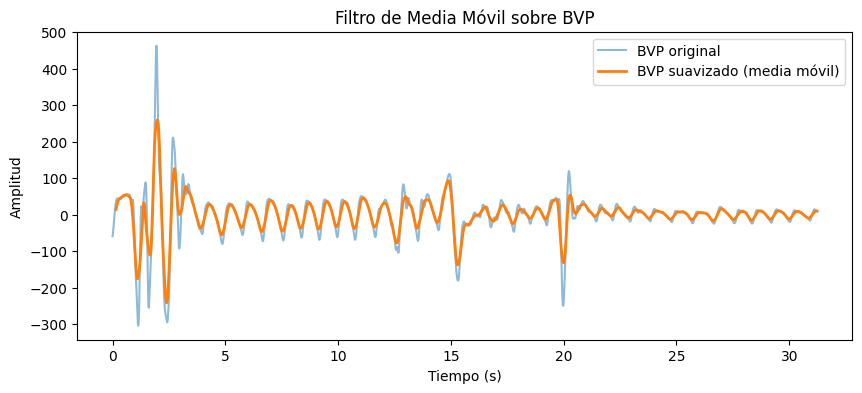

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Definir el tamaño de la ventana de suavizado (en número de muestras)
window_size = 20  # Por ejemplo, suaviza en un rango de ~0.23 segundos (15 muestras a 64 Hz)

# Aplicar media móvil centrada
df_merged['BVP_smoothed'] = df_merged['BVP'].rolling(window=window_size, center=True).mean()

df_abstract = pd.DataFrame(df_merged.head(2000))
#df_abstract.plot(kind = "scatter", x="time", y="BVP_smoothed", figsize = (15,5))

plt.figure(figsize=(10, 4))
plt.plot(df_abstract['time'], df_abstract['BVP'], label='BVP original', alpha=0.5)
plt.plot(df_abstract['time'], df_abstract['BVP_smoothed'], label='BVP suavizado (media móvil)', linewidth=2)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.title('Filtro de Media Móvil sobre BVP')
plt.show()

In [ ]:
def signal_toolkit(df_abstract, BVP, new_col1='valley', new_col2='peak', new_col3='period'):
    df_abstract = df_abstract.copy()

    # valley
    df_abstract[new_col1] = (
        ((df_abstract['BVP_smoothed'] - df_abstract['BVP_smoothed'].shift(1)) > 0) &
        ((df_abstract['BVP_smoothed'].shift(1) - df_abstract['BVP_smoothed'].shift(2)) <= 0)
    ).astype(int)

    # peak
    df_abstract[new_col2] = (
        ((df_abstract['BVP_smoothed'] - df_abstract['BVP_smoothed'].shift(1)) < 0) &
        ((df_abstract['BVP_smoothed'].shift(1) - df_abstract['BVP_smoothed'].shift(2)) >= 0)
    ).astype(int)

    df_abstract['period'] = np.nan  # Nueva columna para almacenar periodos

    startphr = None  # Inicializar startphr como None

    # Recorrer el DataFrame para calcular periodos entre peak y peak
    peaks = df_abstract[df_abstract['peak'] == 1].copy()
    peaks['period'] = peaks['time'].diff()  # diferencia de tiempo entre picos
    df_abstract.loc[peaks.index, 'period'] = peaks['period']

    df_abstract['HR']= 60/peaks['period']

    # Filtrar sólo las filas con peak == 1 y frequency no NaN
    mask = (df_abstract['peak'] == 1) & (df_abstract['HR'].notna())
    freq_peaks = df_abstract.loc[mask, 'HR']
    period_peaks = df_abstract.loc[mask, 'period']

    # Calcular promedio móvil con ventana de tamaño 10
    moving_hr_avg = freq_peaks.rolling(window=10, min_periods=1).mean()
    moving_period_avg = period_peaks.rolling(window=10, min_periods=1).mean()

    # Crear nueva columna y asignar NaN inicialmente
    df_abstract['MEAN_HR'] = np.nan
    df_abstract['MEAN_RR'] = np.nan

    # Poner los promedios móviles sólo en las filas donde peak == 1
    df_abstract.loc[mask, 'MEAN_HR'] = moving_hr_avg.values
    df_abstract.loc[mask, 'MEAN_RR'] = moving_period_avg.values


    # Standard deviation of the moving average (window size 3)
    df_abstract['SDRR'] = period_peaks.rolling(window=10, min_periods=1).std()

    # RMSSD
    rr_diff = peaks['period'].diff()
    rr_diff_sq = rr_diff ** 2
    rolling_mean_sq_diff = rr_diff_sq.rolling(window=9, min_periods=1).mean()
    rmssd_series = np.sqrt(rolling_mean_sq_diff)
    df_abstract.loc[df_abstract['peak'] == 1, 'RMSSD'] = rmssd_series.values

    # SDSD móvil
    sdsd_moving = rr_diff.rolling(window=9, min_periods=1).std()
    df_abstract.loc[df_abstract['peak'] == 1, 'SDSD'] = sdsd_moving.values

    # SDRR_RMSSD
    df_abstract['SDRR_RMSSD'] = df_abstract['SDRR']/df_abstract['RMSSD']

    return df_abstract

In [ ]:
df_abstract = signal_toolkit(df_abstract, BVP='BVP')
df_filtered = df_abstract[df_abstract['peak'] == 1]
print(df_filtered)

           time     BVP  label  BVP_smoothed  valley  peak    period  \
41     0.640625   55.33      0       54.0655       0     1       NaN   
90     1.406250   61.33      0       30.4260       0     1  0.765625   
128    2.000000  336.83      0      257.9325       0     1  0.593750   
177    2.765625  167.61      0      123.2075       0     1  0.765625   
209    3.265625   54.88      0       75.9835       0     1  0.500000   
276    4.312500   28.75      0       27.6070       0     1  1.046875   
336    5.250000   28.57      0       26.6000       0     1  0.937500   
391    6.109375   27.85      0       27.9065       0     1  0.859375   
450    7.031250   37.62      0       38.4905       0     1  0.921875   
507    7.921875   24.59      0       24.6750       0     1  0.890625   
558    8.718750   34.38      0       31.8370       0     1  0.796875   
609    9.515625   37.24      0       35.3375       0     1  0.796875   
659   10.296875   34.66      0       35.5840       0     1  0.78